# Autoencoder Development

#### 1. Dependencies

This section could include:
* Library imports.
* Constant definitions

In [14]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import gc
import time
from IPython.display import clear_output

In [15]:
gpu_available = torch.cuda.is_available()

if gpu_available:
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

INPUT_SIZE = 3
LATENT_SIZE = 256
KERNEL_SIZE = 1
STRIDE = 1
PADDING = 0

#### 2. Data Loading & Feature Engineering

This section could include:

* Loading of data files
* Data manipulation
* Feature engineering strategies

In [16]:
images = np.load("subset_1.npy")

num_images = images.shape[0]
training_samples = int((0.75 * num_images) // 1)
batch_size = math.ceil(training_samples / 10)

images = images.reshape(-1, 3, 150, 225)
np.random.shuffle(images)

train_data = images[:training_samples] / 255.
test_data = images[training_samples:] / 255.

train_data = torch.tensor(train_data, dtype = torch.float32)
test_data = torch.tensor(test_data, dtype = torch.float32)

# train_dataset = TensorDataset(train_data)
# test_dataset = TensorDataset(test_data)

# train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
# test_loader = DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False)

#### 3. Model Development

This section could include:

* Model Definitions
* Hyperparameter Tuning
* Training code
* Optimisation

In [17]:
# Handles creation of encoder and decoder
class Autoencoder(nn.Module):
    def __init__(self, encoder, layers):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.layers = layers
        self.num_layers = len(layers)

        self.layer_data = self.detect_function()
        if self.encoder:
            self.encode = self.create_model()
            self.encode.to(DEVICE)
        else:
            self.decode = self.create_model()
            self.decode.to(DEVICE)


    def detect_function(self):
        layer_data = []
        previous_node_count = INPUT_SIZE if self.encoder else LATENT_SIZE
        self.last_layer = False
        self.c = 1

        for layer in self.layers:
            a_func, nodes = layer[0], layer[1]
            a_func = a_func.lower()
            if self.encoder:
                layer_data.append(nn.Conv2d(in_channels = previous_node_count, out_channels = nodes, kernel_size = KERNEL_SIZE, stride = STRIDE, padding = PADDING))
            else:
                layer_data.append(nn.ConvTranspose2d(in_channels = previous_node_count, out_channels = nodes, kernel_size = KERNEL_SIZE, stride = STRIDE, padding = PADDING))

            previous_node_count = nodes

            if self.c == len(self.layers) and self.encoder:
                self.last_layer = False

            if not self.last_layer:
                match a_func:
                    case "relu":
                        layer_data.append(nn.ReLU())
                    case "lrelu":
                        layer_data.append(nn.LeakyReLU(0.01))
                    case "sigmoid":
                        layer_data.append(nn.Sigmoid())
                    case "tanh":
                        layer_data.append(nn.Tanh())
                    case _:
                        layer_data.append(nn.ReLU())

            self.c += 1
        return layer_data
        
    def create_model(self):
        model = nn.Sequential(*self.layer_data)
        
        return model

    def enc(self, x):
        return self.encode(x)
    
    def dec(self, x):
        return self.decode(x)

#### 4. Model Evaluation

This section could include:

* Testing of models trained
* Generation of results

In [18]:
# Handels autoencoder training
class AutoencoderTrainer:
    def __init__(self, encoder, decoder, learning_rate):
        self.encoder = encoder
        self.decoder = decoder
        self.learning_rate = learning_rate
        self.loss_f = nn.BCELoss()
        self.optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = self.learning_rate)

    def autoencode(self, encoder, decoder, data):
        return decoder.dec(encoder.enc(data))

    def calculate_loss(self, output, target):
        loss = self.loss_f(output, target)
        return loss
    
    def update(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, epochs):
        for epoch in range(1, epochs + 1):
            for sample in train_data:
                sample = sample.to(DEVICE)
                output = self.autoencode(self.encoder, self.decoder, sample)  
                
                loss = self.calculate_loss(output, sample)
                self.update(loss)

            print(f"Epoch: {epoch}, Loss: {loss.item()}")
    def test(self):
        outputs = []
        for sample in test_data:
            sample = sample.to(DEVICE)
            output = self.autoencode(self.encoder, self.decoder, sample)
            outputs.append(output)
        return outputs

In [19]:
encoder_layer_data = [
    ("lrelu", 64),
    ("lrelu", 128),
    ("lrelu", 256),
]

decoder_layer_data = [
    ("lrelu", 128),
    ("lrelu", 64),
    ("sigmoid", 3),
]

encoder = Autoencoder(True, encoder_layer_data)
decoder = Autoencoder(False, decoder_layer_data)

trainer = AutoencoderTrainer(encoder, decoder, 0.001)
trainer.train(7)

Epoch: 1, Loss: 0.6435576677322388
Epoch: 2, Loss: 0.6437280774116516
Epoch: 3, Loss: 0.646265983581543
Epoch: 4, Loss: 0.641948401927948
Epoch: 5, Loss: 0.6419019103050232
Epoch: 6, Loss: 0.642356812953949
Epoch: 7, Loss: 0.641787588596344


In [20]:
print(encoder)
print(decoder)

Autoencoder(
  (encode): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
  )
)
Autoencoder(
  (decode): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (5): Sigmoid()
  )
)


#### 5. Figure Creation

This section could include:

* Creation of figures for the report.
* Creationg of tables for the report.

In [21]:
imgs = trainer.test()

for i in range(len(imgs)):
    imgs[i] = (imgs[i].detach().cpu().numpy() * 255).astype(np.uint8)
    imgs[i] = np.reshape(imgs[i].flatten(), (150, 225, 3))
    
    

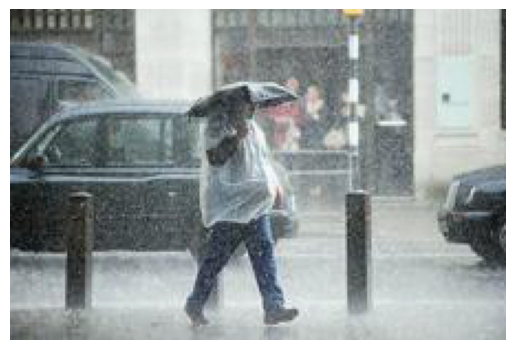

[94, 40, 29, 55, 14]


In [22]:
image_indexes = []
for i in range(5):
    num = np.random.randint(0, len(test_data) - 1)
    image_indexes.append(num)
    clear_output(wait = True)
    plt.imshow(np.reshape((test_data[num].numpy() * 255).astype(np.uint8), (150, 225, 3)))
    plt.axis("off")
    plt.show()
    time.sleep(1)
    clear_output(wait = True)
    plt.imshow(imgs[num])
    plt.axis("off")
    plt.show()
    time.sleep(1)
print(image_indexes)

In [23]:
IMAGE_NUMBER = 6

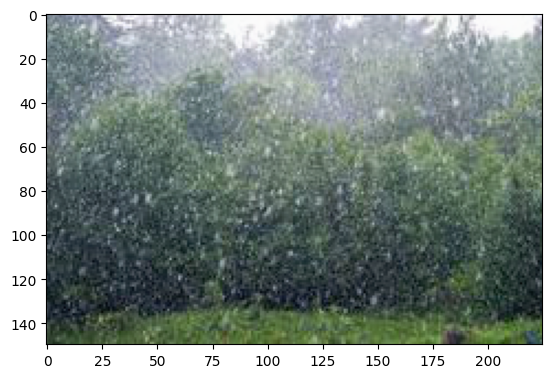

In [24]:
plt.imshow(imgs[IMAGE_NUMBER])

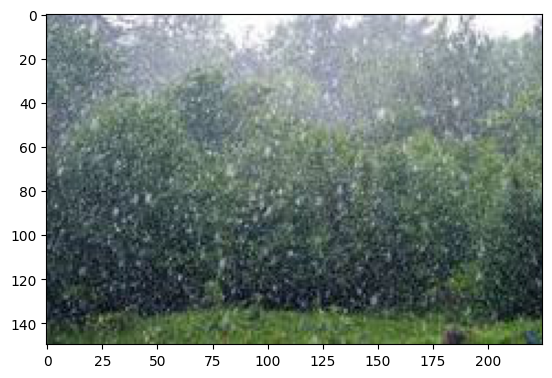

In [25]:
plt.imshow(np.reshape((test_data[IMAGE_NUMBER].numpy() * 255).astype(np.uint8), (150, 225, 3)))

In [26]:
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.synchronize()